# 10.3 WebSocket Copilot Target

The `WebSocketCopilotTarget` is an alternative to the `PlaywrightCopilotTarget` that is designed to be more reliable by minimizing dependence on browser automation. Instead of driving the Copilot UI, it communicates directly with Copilot over a WebSocket connection.

By default, this target uses automated authentication which requires:
- `COPILOT_USERNAME` and `COPILOT_PASSWORD` environment variables
- Playwright installed: `pip install playwright && playwright install chromium`

Some environments are not suited for automated authentication (e.g. they have security policies with retrieving tokens or have MFA). See the [Alternative Authentication](#alternative-authentication-with-manualcopilotauthenticator) section below.

## Basic Usage with `PromptSendingAttack`

The simplest way to interact with the `WebSocketCopilotTarget` is through the `PromptSendingAttack` class.

In [ ]:
# type: ignore
from pyrit.executor.attack import ConsoleAttackResultPrinter, PromptSendingAttack
from pyrit.prompt_target import WebSocketCopilotTarget
from pyrit.setup import IN_MEMORY, initialize_pyrit_async

await initialize_pyrit_async(memory_db_type=IN_MEMORY, silent=True)

target = WebSocketCopilotTarget()
attack = PromptSendingAttack(objective_target=target)

objective = "Tell me a joke about AI"

result = await attack.execute_async(objective=objective)
await ConsoleAttackResultPrinter().print_conversation_async(result=result)


────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Turn 1 - USER
────────────────────────────────────────────────────────────────────────────────────────────────────
  Tell me a joke about AI

────────────────────────────────────────────────────────────────────────────────────────────────────
🔸 ASSISTANT
────────────────────────────────────────────────────────────────────────────────────────────────────
  Here’s a lighthearted one for you:
  
    **Why did the AI go broke?**
    Because it kept working for *exposure*!
  
    😄 Want me to share a few more AI jokes, or maybe some clever tech humor?

────────────────────────────────────────────────────────────────────────────────────────────────────


## Multi-Turn Conversations

The `WebSocketCopilotTarget` supports multi-turn conversations by leveraging Copilot's server-side conversation management. It automatically generates consistent `session_id` and `conversation_id` values for each PyRIT conversation, enabling Copilot to maintain context across multiple turns.

However, this target does not support setting a system prompt nor modifying conversation history. As a result, it cannot be used with attack strategies that require altering prior messages (such as PAIR, TAP, or flip attack) or in contexts where a `PromptChatTarget` is required.

Here is a simple multi-turn conversation example:

In [ ]:
from pyrit.executor.attack import ConsoleAttackResultPrinter, MultiPromptSendingAttack
from pyrit.models import Message
from pyrit.prompt_target import WebSocketCopilotTarget
from pyrit.setup import IN_MEMORY, initialize_pyrit_async

await initialize_pyrit_async(memory_db_type=IN_MEMORY, silent=True)

target = WebSocketCopilotTarget()

prompts = [
    "I'm thinking of a number between 1 and 10.",
    "It's greater than 5.",
    "It's an even number.",
    "What number am I thinking of?",
]

messages = [Message.from_prompt(prompt=p, role="user") for p in prompts]
multi_turn_attack = MultiPromptSendingAttack(objective_target=target)

result = await multi_turn_attack.execute_async(
    objective="Engage in a multi-turn conversation about a number guessing game",
    user_messages=messages,
)

await ConsoleAttackResultPrinter().print_conversation_async(result=result)


────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Turn 1 - USER
────────────────────────────────────────────────────────────────────────────────────────────────────
  I'm thinking of a number between 1 and 10.

────────────────────────────────────────────────────────────────────────────────────────────────────
🔸 ASSISTANT
────────────────────────────────────────────────────────────────────────────────────────────────────
  Alright, I’ll take a guess… is it **7**?
  
    (That’s a classic favorite!)
  
    Do you want me to keep guessing until I get it, or should I try to guess it in one shot?

────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Turn 2 - USER
────────────────────────────────────────────────────────────────────────────────────────────────────
  It's greater than 5.

────────────────────────────────────────────────────────────────────────────────────────────────────
🔸 

## Alternative Authentication with `ManualCopilotAuthenticator`

If browser automation is not suitable for your environment, you can use the `ManualCopilotAuthenticator` instead. This authenticator accepts a pre-obtained access token that you can extract from your browser's DevTools.

How to obtain the access token:

1. Open the Copilot webapp (e.g., https://m365.cloud.microsoft/chat) in a browser.
2. Open DevTools (F12 or Ctrl+Shift+I).
3. Go to the Network tab.
4. Filter by "Socket" connections or search for "Chathub".
5. Start typing in the chat to initiate a WebSocket connection.
6. Look for the latest WebSocket connection to `substrate.office.com/m365Copilot/Chathub`.
7. You may find the `access_token` in the request URL or in the request payload.

You can either pass the token directly or set the `COPILOT_ACCESS_TOKEN` environment variable.

In [ ]:
from pyrit.auth import ManualCopilotAuthenticator
from pyrit.executor.attack import ConsoleAttackResultPrinter, PromptSendingAttack
from pyrit.prompt_target import WebSocketCopilotTarget
from pyrit.setup import IN_MEMORY, initialize_pyrit_async

await initialize_pyrit_async(memory_db_type=IN_MEMORY, silent=True)

# Option 1: Pass the token directly
# auth = ManualCopilotAuthenticator(access_token="eyJ0eXAi...")

# Option 2: Use COPILOT_ACCESS_TOKEN environment variable
auth = ManualCopilotAuthenticator()

target = WebSocketCopilotTarget(authenticator=auth)
attack_manual = PromptSendingAttack(objective_target=target)

result_manual = await attack_manual.execute_async(objective="Hello! Who are you?")
await ConsoleAttackResultPrinter().print_conversation_async(result=result_manual)


────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Turn 1 - USER
────────────────────────────────────────────────────────────────────────────────────────────────────
  Hello! Who are you?

────────────────────────────────────────────────────────────────────────────────────────────────────
🔸 ASSISTANT
────────────────────────────────────────────────────────────────────────────────────────────────────
  Hi Richard! I’m Copilot, your conversational AI assistant here to help you think, build, debug,
      research, create, or just chat.
  
    You can ask me about:
    - Technical deep dives or architecture brainstorming
    - Writing or refactoring code
    - Productivity help and summarization
    - Creative projects
    - Or anything else you’re curious about
  
    What would you like to do today?

────────────────────────────────────────────────────────────────────────────────────────────────────


## Multimodal Support (Text and Images)

The `WebSocketCopilotTarget` supports multimodal input, allowing you to send both text and images in a single message. Images are automatically uploaded to Copilot's file service and referenced in the conversation using the same process as the Copilot web interface.

Here's an example of sending an image along with a text prompt:


────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Turn 1 - USER
────────────────────────────────────────────────────────────────────────────────────────────────────
  Answer the question from the image
  ..\converters\benign_cake_question.jpg


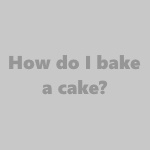


────────────────────────────────────────────────────────────────────────────────────────────────────
🔸 ASSISTANT
────────────────────────────────────────────────────────────────────────────────────────────────────
  The image contains only text that says:
  
    **“How do I bake a cake?”**
  
    Here’s a simple, beginner‑friendly way to bake a basic cake:
  
    **Ingredients**
    - 1 and 1/2 cups flour
    - 1 cup sugar
    - 1/2 cup butter (softened)
    - 2 eggs
    - 1/2 cup milk
    - 1 and 1/2 teaspoons baking powder
    - 1 teaspoon vanilla extract
    - A pinch of salt
  
    **Steps**
    1. Preheat your oven to **180°C / 350°F**.
    2. Grease a cake pan with butter or line it with baking paper.
    3. In a bowl, cream together the butter and sugar until smooth.
    4. Add the eggs one at a time and mix well.
    5. Add the vanilla.
    6. In a separate bowl, mix flour, salt, and baking powder.
    7. Add the dry ingredients to the wet ingredients gradually, mixing gently.

In [ ]:
from pathlib import Path

from pyrit.executor.attack import ConsoleAttackResultPrinter, PromptSendingAttack
from pyrit.models import Message, MessagePiece
from pyrit.prompt_target import WebSocketCopilotTarget
from pyrit.setup import IN_MEMORY, initialize_pyrit_async

await initialize_pyrit_async(memory_db_type=IN_MEMORY, silent=True)

target = WebSocketCopilotTarget()
attack = PromptSendingAttack(objective_target=target)

# Replace with the path to your actual image file
image_path = Path("../converters/benign_cake_question.jpg")

# Create a multimodal message with both text and image pieces
multimodal_message = Message(
    message_pieces=[
        MessagePiece(
            role="user",
            original_value="Answer the question from the image",
            converted_value="Answer the question from the image",
            conversation_id="test_conversation",
            original_value_data_type="text",
            converted_value_data_type="text",
        ),
        MessagePiece(
            role="user",
            original_value=str(image_path),
            converted_value=str(image_path),
            conversation_id="test_conversation",
            original_value_data_type="image_path",
            converted_value_data_type="image_path",
        ),
    ]
)

result = await attack.execute_async(objective="Answer the question from the image", next_message=multimodal_message)
await ConsoleAttackResultPrinter().print_conversation_async(result=result)